In [1]:
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [2]:

DATA_DIR = 'E:\Face Mask Dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [3]:

IMG_SIZE = 227
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)



['without_mask', 'with_mask']


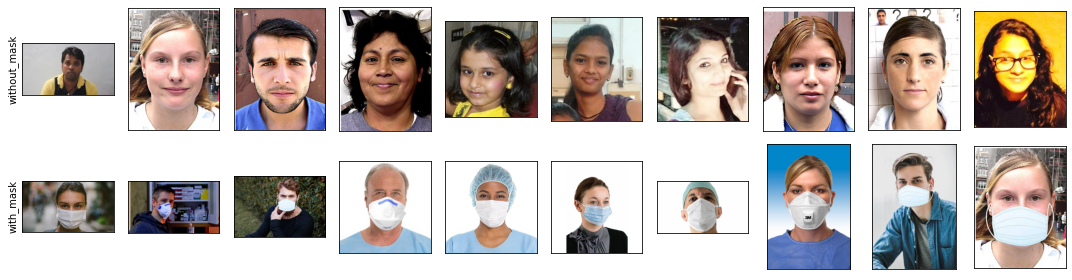

In [4]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [5]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) # 'E:\Face Mask Dataset\train\with_mask'
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(training_data))

100%|███████████████████████████████████████████████████████████████████████████████| 658/658 [00:05<00:00, 110.95it/s]

1315


In [6]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(valid_data))

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 149.13it/s]

142


In [7]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 84.62it/s]

194


In [8]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)


In [9]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,227,227,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (1315, 227, 227, 3) Y_train= (1315,)


In [10]:
X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)
    
X_valid = np.array(X_valid).astype('float32').reshape(-1,227,227,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (142, 227, 227, 3) Y_valid= (142,)


In [11]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (194, 227, 227, 3) Y_test= (194,)


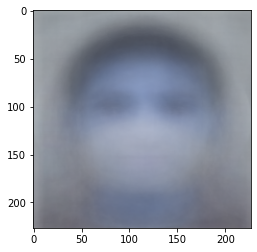

In [12]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [13]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

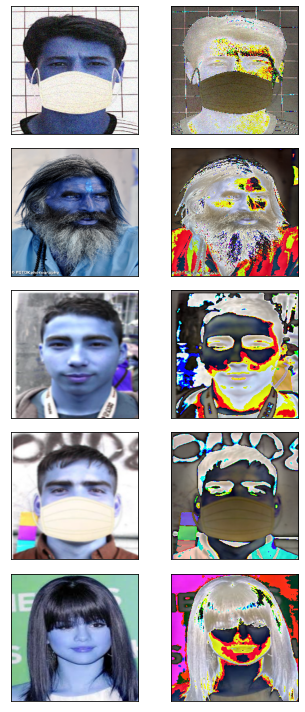

In [14]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [15]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(2),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

In [16]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [17]:
h = model.fit(x=X_train_norm, y=Y_train, epochs=50, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Epoch 1/50
42/42 [==============================] - 54s 1s/step - loss: 0.8194 - accuracy: 0.8913 - val_loss: 5.1914 - val_accuracy: 0.9577
Epoch 2/50
42/42 [==============================] - 53s 1s/step - loss: 0.1570 - accuracy: 0.9574 - val_loss: 2.2834 - val_accuracy: 0.9014
Epoch 3/50
42/42 [==============================] - 57s 1s/step - loss: 0.2215 - accuracy: 0.9308 - val_loss: 1.3192 - val_accuracy: 0.9296
Epoch 4/50
42/42 [==============================] - 59s 1s/step - loss: 0.1974 - accuracy: 0.9430 - val_loss: 0.2955 - val_accuracy: 0.9648
Epoch 5/50
42/42 [==============================] - 57s 1s/step - loss: 0.1237 - accuracy: 0.9582 - val_loss: 0.2442 - val_accuracy: 0.9718
Epoch 6/50
42/42 [==============================] - 59s 1s/step - loss: 0.1411 - accuracy: 0.9597 - val_loss: 0.1156 - val_accuracy: 0.9789
Epoch 7/50
42/42 [==============================] - 56s 1s/step - loss: 0.1296 - accuracy: 0.9574 - val_loss: 0.0283 - val_accuracy: 0.9859
Epoch 8/50
42/42 [==

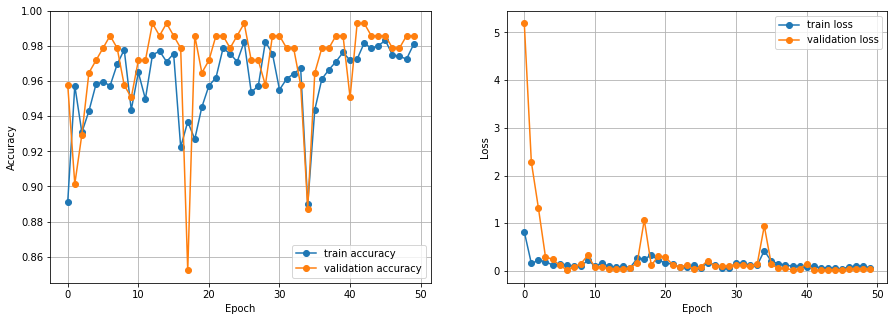

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [19]:
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss) 

7/7 [==============================] - 2s 258ms/step - loss: 0.1065 - accuracy: 0.9639

Test Accuracy: 0.9639175534248352

Test Loss: 0.10652311146259308


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



cascPath = os.path.dirname(cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)



video_capture = cv2.VideoCapture(0)

if not video_capture.isOpened():
    print("Unable to access the camera")
else:
    print("Access to the camera was successfully obtained")

print("Streaming started")
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(227, 227),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list=[]
    preds=[]
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (227, 227))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame = preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
            (with_mask, without_mask) = pred
        label = "Mask" if with_mask > without_mask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(with_mask, without_mask) * 100)
        cv2.putText(frame, label, (x, y- 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)



        cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
        # Display the resulting frame
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
   
video_capture.release()
cv2.destroyAllWindows()

Access to the camera was successfully obtained
Streaming started
